# Using the `combined_qa` asset

This notebook demonstrates the process of:
* Searching a collection to intersect a point location between a start date and end date
* Examining the `combined_qa` asset alongside the `lst` asset
* Describing the values present in the `combined_qa` asset
* Masking the `lst` asset with values from the `combined_qa` asset

Let's import the required packages

In [1]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from shapely.geometry import box, mapping, Point, Polygon
from pyproj.crs import CRS
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

import os
import base64

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# supress warnings from numpy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

We'll define a helper function to plot the `lst` and `combined_qa` assets side-by-side, as well as masking or keeping particular QA values. This also exists in `FH_Hydrosat` but is included here for descriptive purposes.

In [2]:
def plot_lst_and_qa(hdst_item, mask_val=None, keep_val=None):
    
    mask_href = hdst_item.to_dict()['assets']['combined_qa']['href']
    with rio.open(mask_href) as src:
        qa = src.read(1)

    lst_href = hdst_item.to_dict()['assets']['lst']['href']
    with rio.open(lst_href) as src:
        lst = src.read(1)
     
    ## apply masking or keeping of values
    # if a mask_val was provided, use it to set those pixels to np.nan so they won't be used 
    # for analysis or visualizaton. This can be done by numpy's `where` function, which operates as
    # np.where(condition, value_if_true, value_if_false)
    # if there are multiple values in a list to mask, we will mask each one sequentially.
    if mask_val is not None:
        
        # if a list of mask values was provided, sequentially set the lst data where the QA data 
        # matches those values to np.nan
        if type(mask_val) == list:
            for mv in mask_val:
                lst = np.where(qa == mask_val, np.nan, lst)
        elif type(mask_val) == float:
            
            # if only one value supplied to mask, us np.where() to set the lst data
            # to np.nan where that condition is true
            lst = np.where(qa == mask_val, np.nan, lst)
        else:
            raise ValueError("mask_val must be either float or list of floats")
    
    # if a keep_val was provided, use it to set pixels not equal to those values to np.nan so 
    # they won't be used for analysis or visualizaton. This can be done with boolean logic and indexing
    # directly into the array. if there are multiple values, we will sequentially OR the mask as more values
    # are used.
    if keep_val is not None:
        if type(keep_val) == list:
            
            # if it's a list, there should be multiple values. iterate through them.
            for i,kv in enumerate(keep_val):
                # build keep mask
                if i == 0:
                    keep_mask = qa == kv
                else:
                    keep_mask = keep_mask | (qa == kv)
            
            # take the complement of the keep_mask to retain only lst data where the QA values match
            # the provided list.
            lst[~keep_mask] = np.nan
                
        elif type(keep_val) == float:
            
            # if only one value provided to keep, set the lst data not equal to that value to np.nan
            lst[qa != keep_val] = np.nan
        else:
            raise ValueError("keep_val must be either float or list of floats")
        

    ## display the data side-by-side
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    im = ax[0].imshow(lst, cmap='inferno')
    ax[0].set_title('HDST')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    #### make a unique value colormap for the QA data
    cmap = plt.cm.cividis  # define the colormap
    # extract all colors from the cmap
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    num_vals = int(np.unique(qa).shape[0])
    bounds = np.linspace(0, num_vals, num_vals)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    im = ax[1].imshow(qa, cmap=cmap, norm=norm)
    ax[1].set_title('COMBINED_QA')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
                              ticks=bounds+0.5, boundaries=bounds, format='%1i')

    cbar.ax.set_yticklabels(np.unique(qa))

    [a.axis('off') for a in ax]

    plt.show()
    
    return

If you see `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed`, do not fret, and proceed.

This next cell opens a file `creds.json` which you will need to create in the same directory as the notebook. The format of the file should be:

```
{
"username":"your_username",
"password":"your_password"
}
```

and you have updated with your username and password. 

In [3]:
with open('creds.json') as f:
    creds = json.loads(f.read())
    

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint.

In [6]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

We'll search for data in the `starfm_predictions_modis_landsat` and `pydms_sharpened_landsat` collections which intersect a point location between a start date and an end date and print out the number of items. 

In [7]:
geom = {'type': 'Point', 'coordinates': [-120.21102905273436,36.535019209789]} # Point for Hanford, CA, USA

collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
start_date = "2021-08-17T00:00:00Z"
end_date = "2021-10-30T00:00:00Z"

search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
items = list(search.get_all_items()) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time
len(items)

66

This next cell will determine if the data returned covers more than a single MGRS tile. If there is, choose one of the tiles to subset the list of returned items.

In [8]:
mgrs_tiles = []
for i in items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
print(f'number of tiles in query: {len(set(mgrs_tiles))}, {set(mgrs_tiles)}')

# if there is more than one tile, uncomment and execute this next line to choose the MGRS tile you are interested in
# items = [i for i in items if mgrs_tiles[0] in i.id]

number of tiles in query: 1, {'10SGF'}


## Applying a mask to a single asset

We'll choose an arbitrary dataset from the results to demonstrate the contents of the `combined_qa` asset in relation to the HDST asset. We provide a function to unpack the values from the `combined_qa` asset, but the user is referred to our documentation for the full list of possible values.

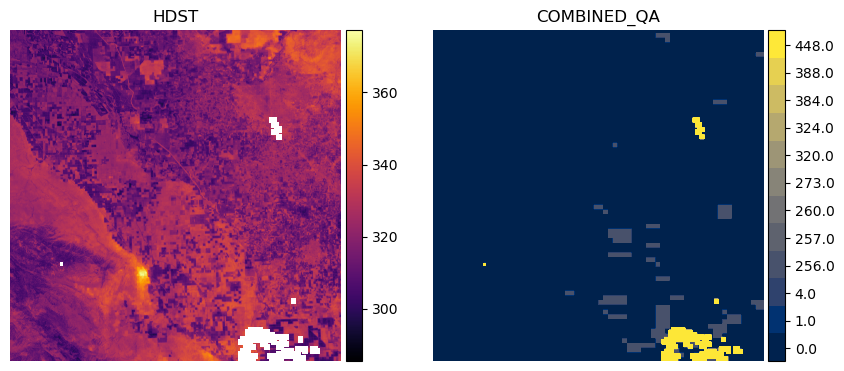

In [9]:
item_num = 1
plot_lst_and_qa(items[item_num])

In [10]:
from FH_Hydrosat import unpack_qa_value

In [11]:
# read in the combined_qa asset
qa_href = items[item_num].to_dict()['assets']['combined_qa']['href']
with rio.open(qa_href) as src:
    qa = src.read(1)
    
# unpack the value and extract the qa label
for val in np.unique(qa):
    print(f"{val}: {unpack_qa_value(val)}")

0.0: ['valid pixel in all inputs']
1.0: ['Prepared High-Resolution t0']
4.0: ['Prepared Low-Resolution t0']
256.0: ['Fused t1']
257.0: ['Prepared High-Resolution t0', 'Fused t1']
260.0: ['Prepared Low-Resolution t0', 'Fused t1']
273.0: ['Prepared High-Resolution t0', 'Sharpened High-Resolution t0', 'Fused t1']
320.0: ['Sharpened Low-Resolution t0', 'Fused t1']
324.0: ['Prepared Low-Resolution t0', 'Sharpened Low-Resolution t0', 'Fused t1']
384.0: ['Sharpened Low-Resolution t1', 'Fused t1']
388.0: ['Prepared Low-Resolution t0', 'Sharpened Low-Resolution t1', 'Fused t1']
448.0: ['Sharpened Low-Resolution t0', 'Sharpened Low-Resolution t1', 'Fused t1']
452.0: ['Prepared Low-Resolution t0', 'Sharpened Low-Resolution t0', 'Sharpened Low-Resolution t1', 'Fused t1']


This says we have mostly valid data across the inputs (0.0), but in some areas we have missing data in the high-resolution LST input at time t0 (1.0) and the low-resolution LST input at t0 (4.0). Generally, the more input datasets which contribute to the HDST data that have NoData, the higher the value in the `combined_qa` asset.

We can filter out pixels in the HDST data which do not come from clear observations in all inputs by *keeping* only LST pixels which match where `combined_qa == 0.0`.

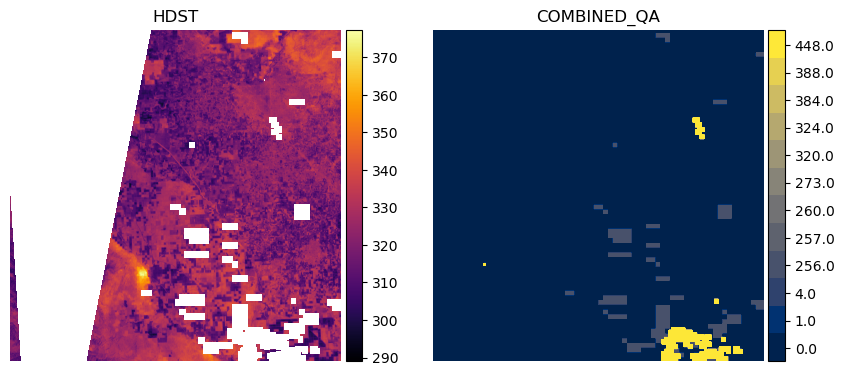

In [12]:
plot_lst_and_qa(items[item_num], keep_val=0.0)

This shows us that we have a swath of data missing on the western side of tile 10SGF for this particular item, which is often due to the orbit of Landsat and its data as clipped within the MGRS tile. If we want to keep data that may have been missing in the MODIS input LST (1.0) and Landsat input LST (4.0), we can do that as follows:

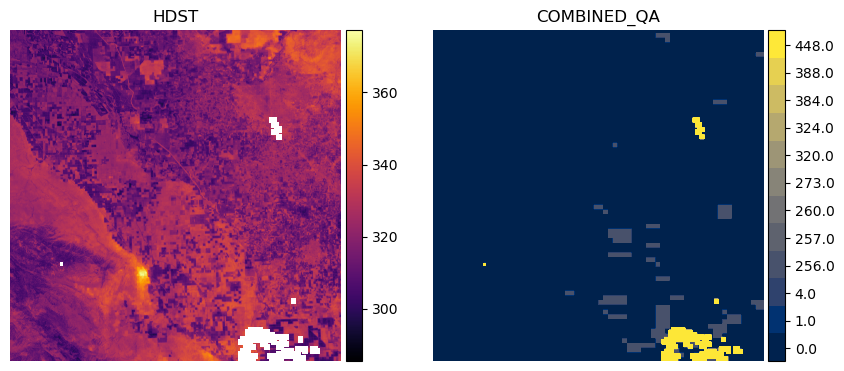

In [13]:
plot_lst_and_qa(items[item_num], keep_val=[0.0, 1.0, 4.0])

Alternatively, we can *mask* pixels in the LST where the `combined_qa` asset tells us we had poor input data everywhere else besides the prepped high resolution and low-resolution input. We can extract the values from the `combined_qa` asset and pass that list as the `mask_val` argument to our helper function. This will result the same data as above.

In [14]:
qa_vals = np.unique(qa) # from above
qa_vals_to_mask = list(qa_vals[qa_vals > 4.0])
print(qa_vals_to_mask)

[256.0, 257.0, 260.0, 273.0, 320.0, 324.0, 384.0, 388.0, 448.0, 452.0]


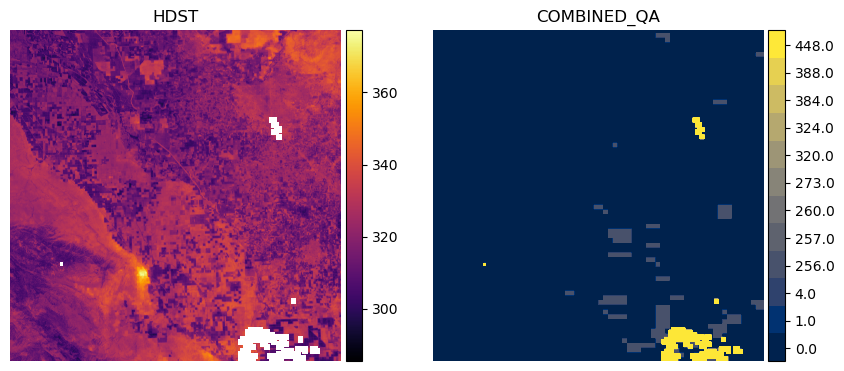

In [15]:
plot_lst_and_qa(items[item_num], mask_val=qa_vals_to_mask)

## More Advanced Application: Applying the mask to a time series of data

Now we'll pass the first 25 items to the `FH_Hydrosat` class and stack the items into an `xarray` `DataArray` for both the `lst` and `combined_qa` assets.

In [16]:
from FH_Hydrosat import FH_Hydrosat

In [17]:
hdst_res = FH_Hydrosat(items[:25]) # lst is the default asset
hdst_stacked_res = hdst_res.stack()
hdst_ds = hdst_stacked_res.ds.sortby('time')
hdst_ds

,Array,Chunk
Bytes,2.81 GiB,16.00 MiB
Shape,"(25, 1, 5490, 5490)","(1, 1, 2048, 2048)"
Count,700 Tasks,225 Chunks
Type,float32,numpy.ndarray


In [18]:
qa_res = FH_Hydrosat(items[:25], asset='combined_qa')
qa_stacked_res = qa_res.stack()
qa_ds = qa_stacked_res.ds.sortby('time')
qa_ds

,Array,Chunk
Bytes,2.81 GiB,16.00 MiB
Shape,"(25, 1, 5490, 5490)","(1, 1, 2048, 2048)"
Count,700 Tasks,225 Chunks
Type,float32,numpy.ndarray


The `DataArray` is quite large if we try to access all of the data. For ease of computation, we'll subset the `DataArray` by a polygon, which will be generated by creating a rectangular buffer around the point location by 1km on either side.

In [19]:
p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

In [20]:
raster_crs = CRS.from_wkt(hdst_ds.spatial_ref.crs_wkt)
buffer_dist = 1000 # 1km in local UTM zone
poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer


Let's plot the polygon on a Folium map so we can see where we are extracting the data

In [21]:
import folium 

# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = gpd.GeoDataFrame(poly_df.to_crs(epsg=4326))

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=13, tiles='CartoDB positron')

# add the polygon and centroid
for _, r in df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    
    geo_j.add_to(m)
    
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)
    
m

Now let's clip both of the HDST and QA datasets with the geometry using `rioxarray`'s `rio` utility package

In [22]:
from FH_Hydrosat import FH_StackedDataset

In [23]:
# clip the raster dataset and cast to a class with slightly more functions
hdst_clipped = FH_StackedDataset(hdst_ds.rio.clip(poly_df.geometry))
hdst_ds_clip = hdst_clipped.ds

qa_clipped = FH_StackedDataset(qa_ds.rio.clip(poly_df.geometry))
qa_ds_clip = qa_clipped.ds

Now that we have a smaller `DataArray`, let's plot the HDST and QA contents according to the `time` dimension using `xarray`'s plot utility.

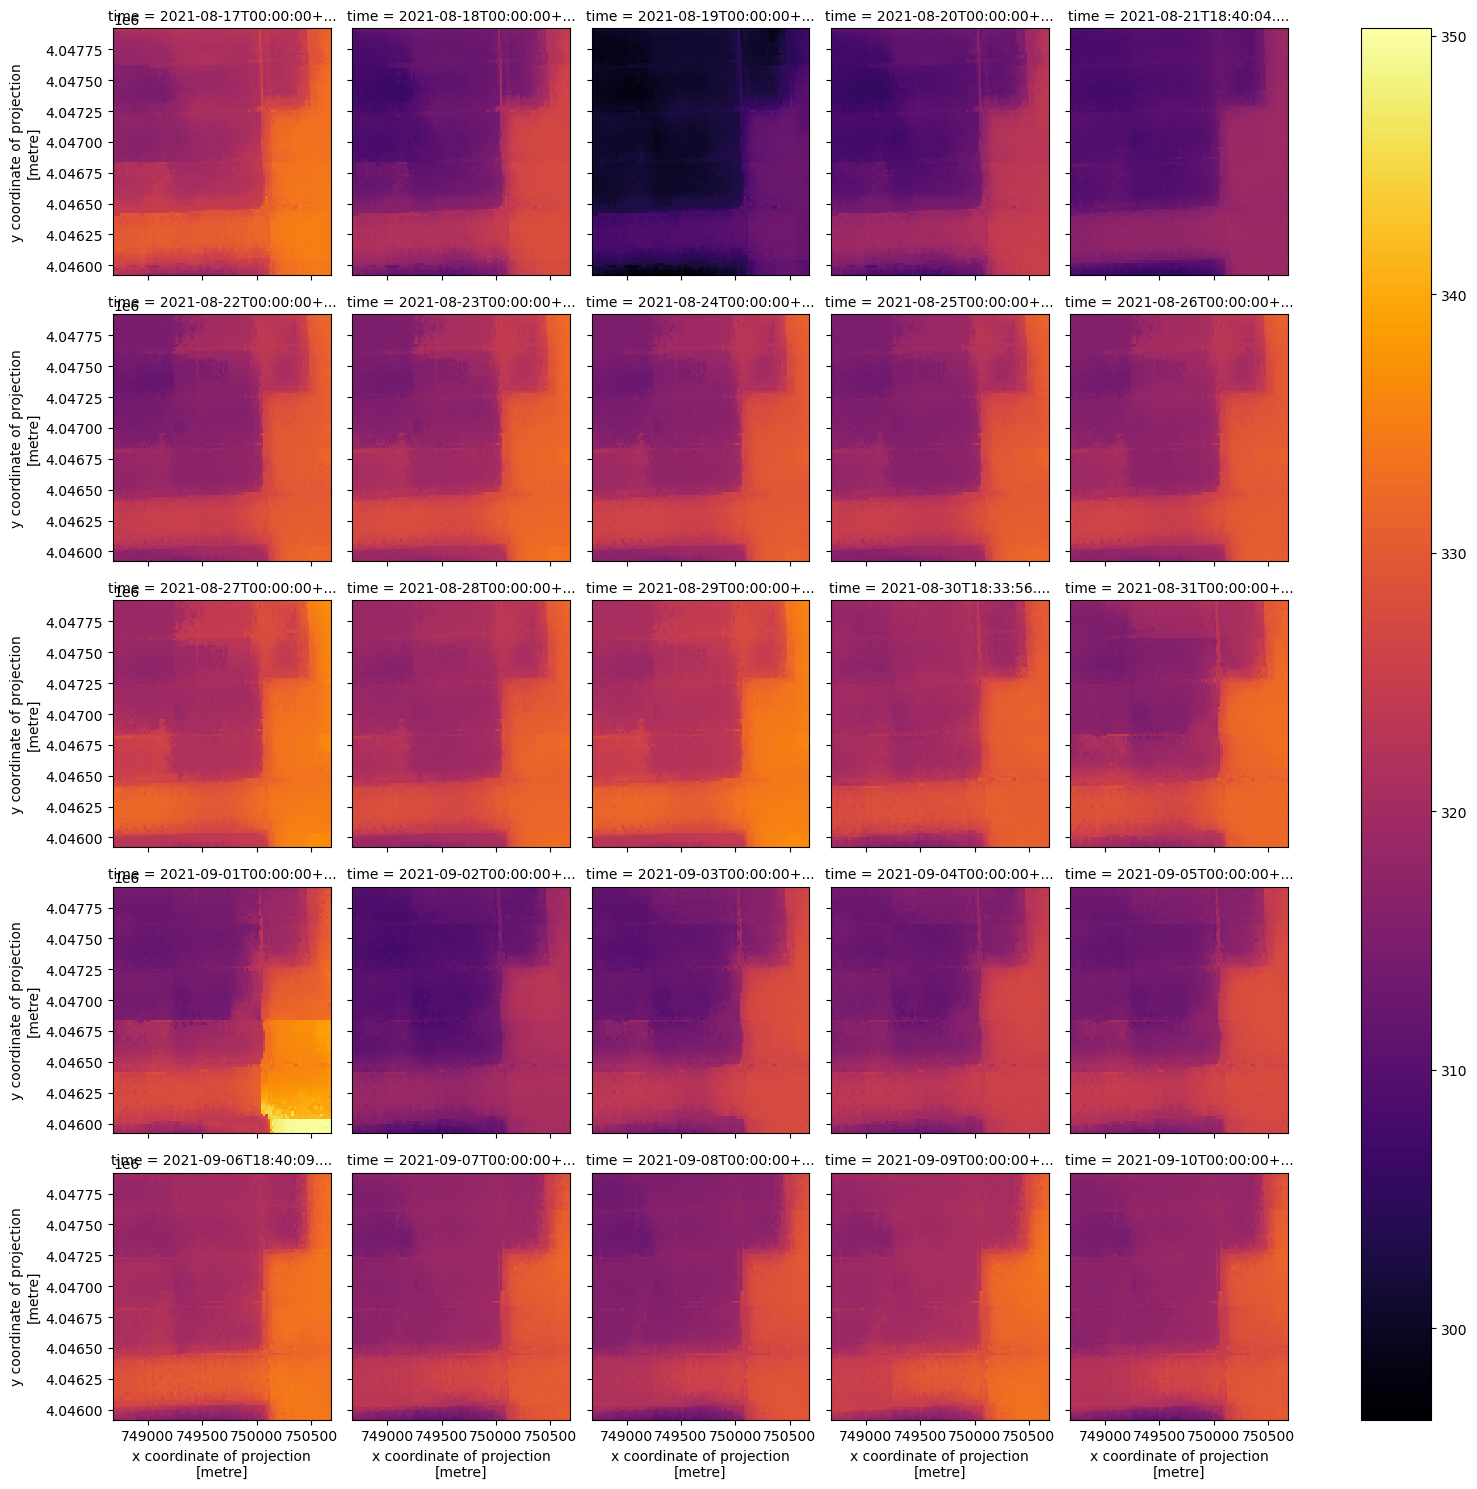

In [24]:
hdst_ds_clip.plot(x='x', y='y', col='time', col_wrap=5, cmap='inferno');

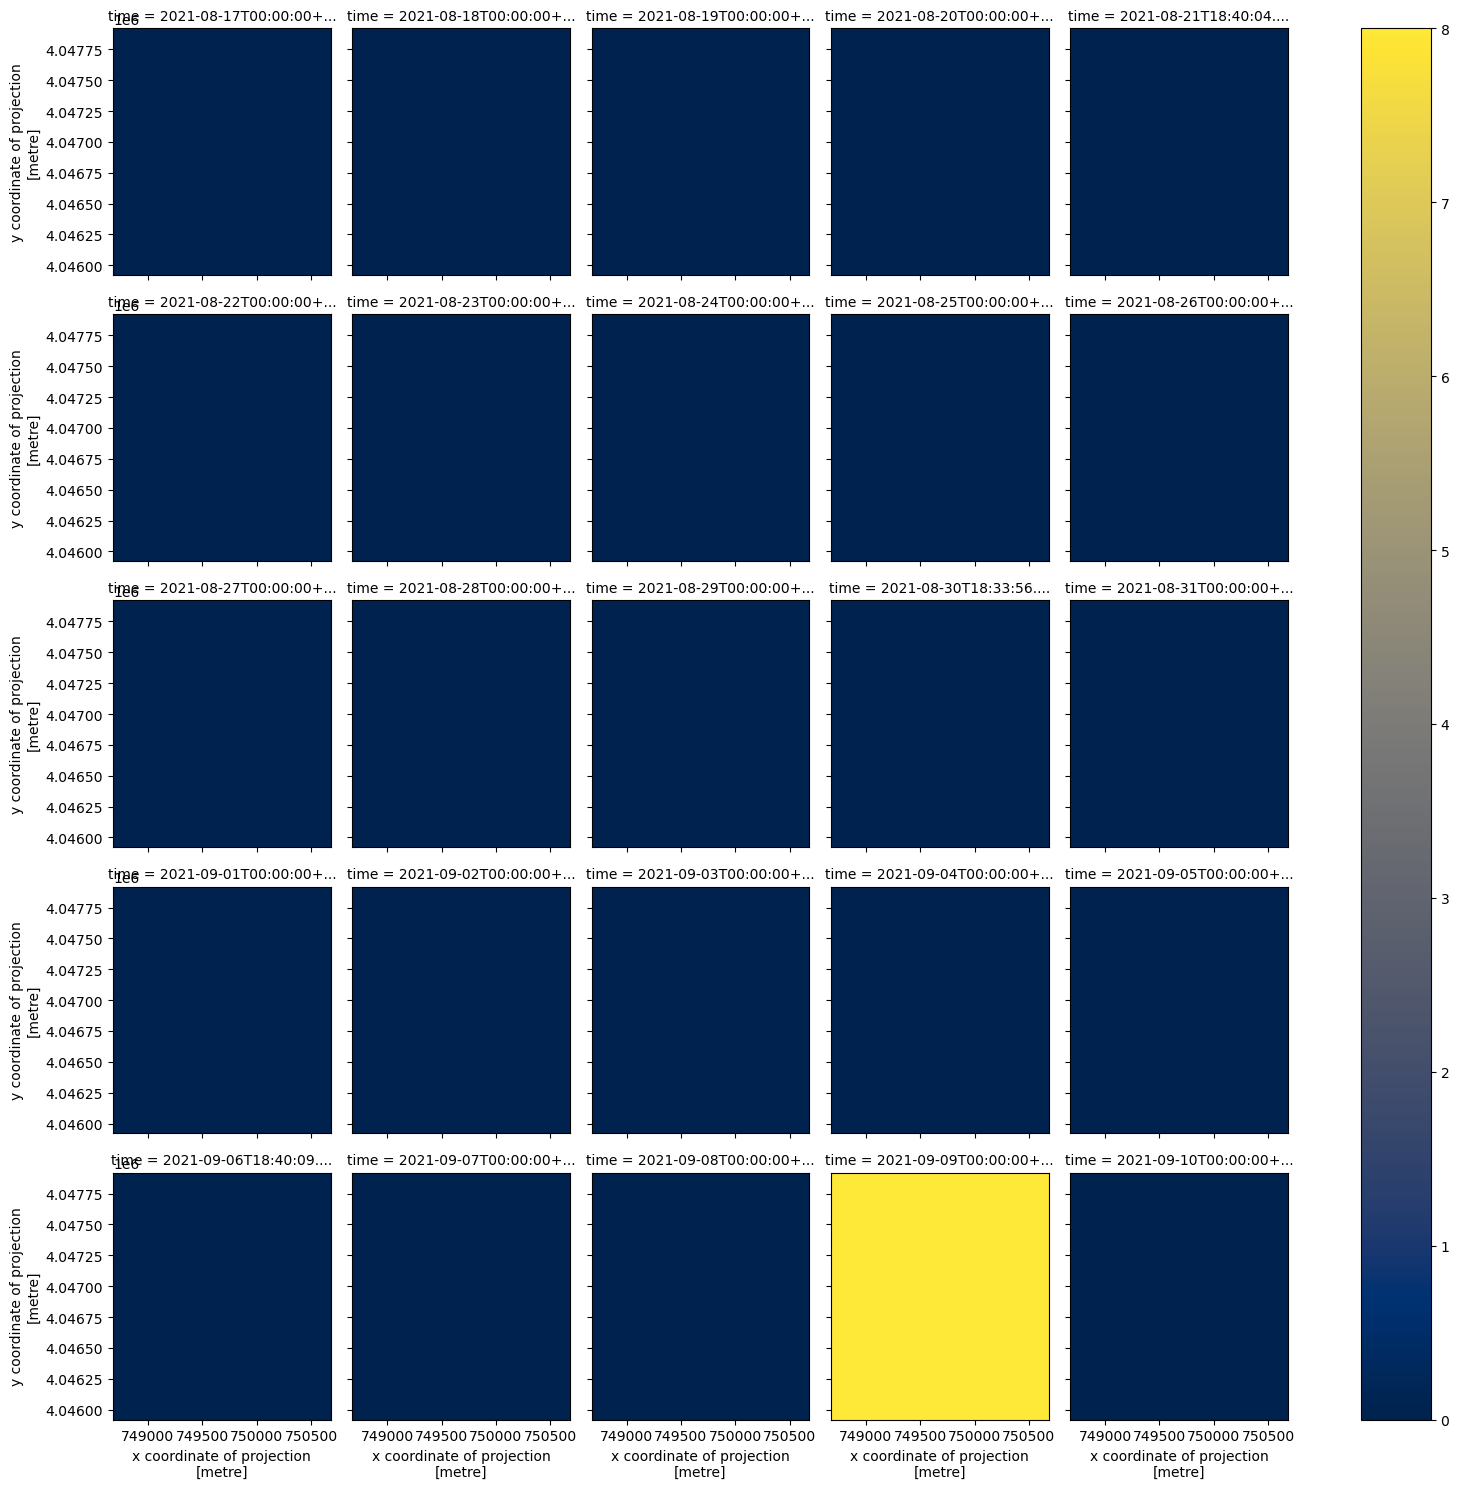

In [25]:
qa_ds_clip.plot(x='x', y='y', col='time', col_wrap=5, cmap='cividis');

For this small area, the `combined_qa` asset is telling us we have good data in all but one date, 2021-09-09. Let's check the qa values in each item of this clipped data.

In [26]:
for date, sub_qa in qa_ds_clip.groupby('time'):
    print(date)
    print(np.unique(sub_qa.values))

2021-08-17 00:00:00+00:00
[0.]
2021-08-18 00:00:00+00:00
[0.]
2021-08-19 00:00:00+00:00
[0.]
2021-08-20 00:00:00+00:00
[0.]
2021-08-21 18:40:04.472248+00:00
[0.]
2021-08-22 00:00:00+00:00
[0.]
2021-08-23 00:00:00+00:00
[0.]
2021-08-24 00:00:00+00:00
[0.]
2021-08-25 00:00:00+00:00
[0.]
2021-08-26 00:00:00+00:00
[0.]
2021-08-27 00:00:00+00:00
[0.]
2021-08-28 00:00:00+00:00
[0.]
2021-08-29 00:00:00+00:00
[0.]
2021-08-30 18:33:56.253740+00:00
[0.]
2021-08-31 00:00:00+00:00
[0.]
2021-09-01 00:00:00+00:00
[0.]
2021-09-02 00:00:00+00:00
[0.]
2021-09-03 00:00:00+00:00
[0.]
2021-09-04 00:00:00+00:00
[0.]
2021-09-05 00:00:00+00:00
[0.]
2021-09-06 18:40:09.219431+00:00
[0.]
2021-09-07 00:00:00+00:00
[0.]
2021-09-08 00:00:00+00:00
[0.]
2021-09-09 00:00:00+00:00
[8.]
2021-09-10 00:00:00+00:00
[0.]


In this dataset, we have all clear observations from the inputs over this point location except for on 2021-09-09, where we have a poor input from the coarse resolution data. Thankfully, the Fusion Hub processing was able to provide data where it would otherwise be missing from the source data.

In [27]:
unpack_qa_value(8.)

['Prepared Low-Resolution t1']

## Plot a time series for the point location

With the same `DataArray`, we can extract the pixel values which intersect a point location. Let's use the same point location we used to search the STAC catalog and plot it.

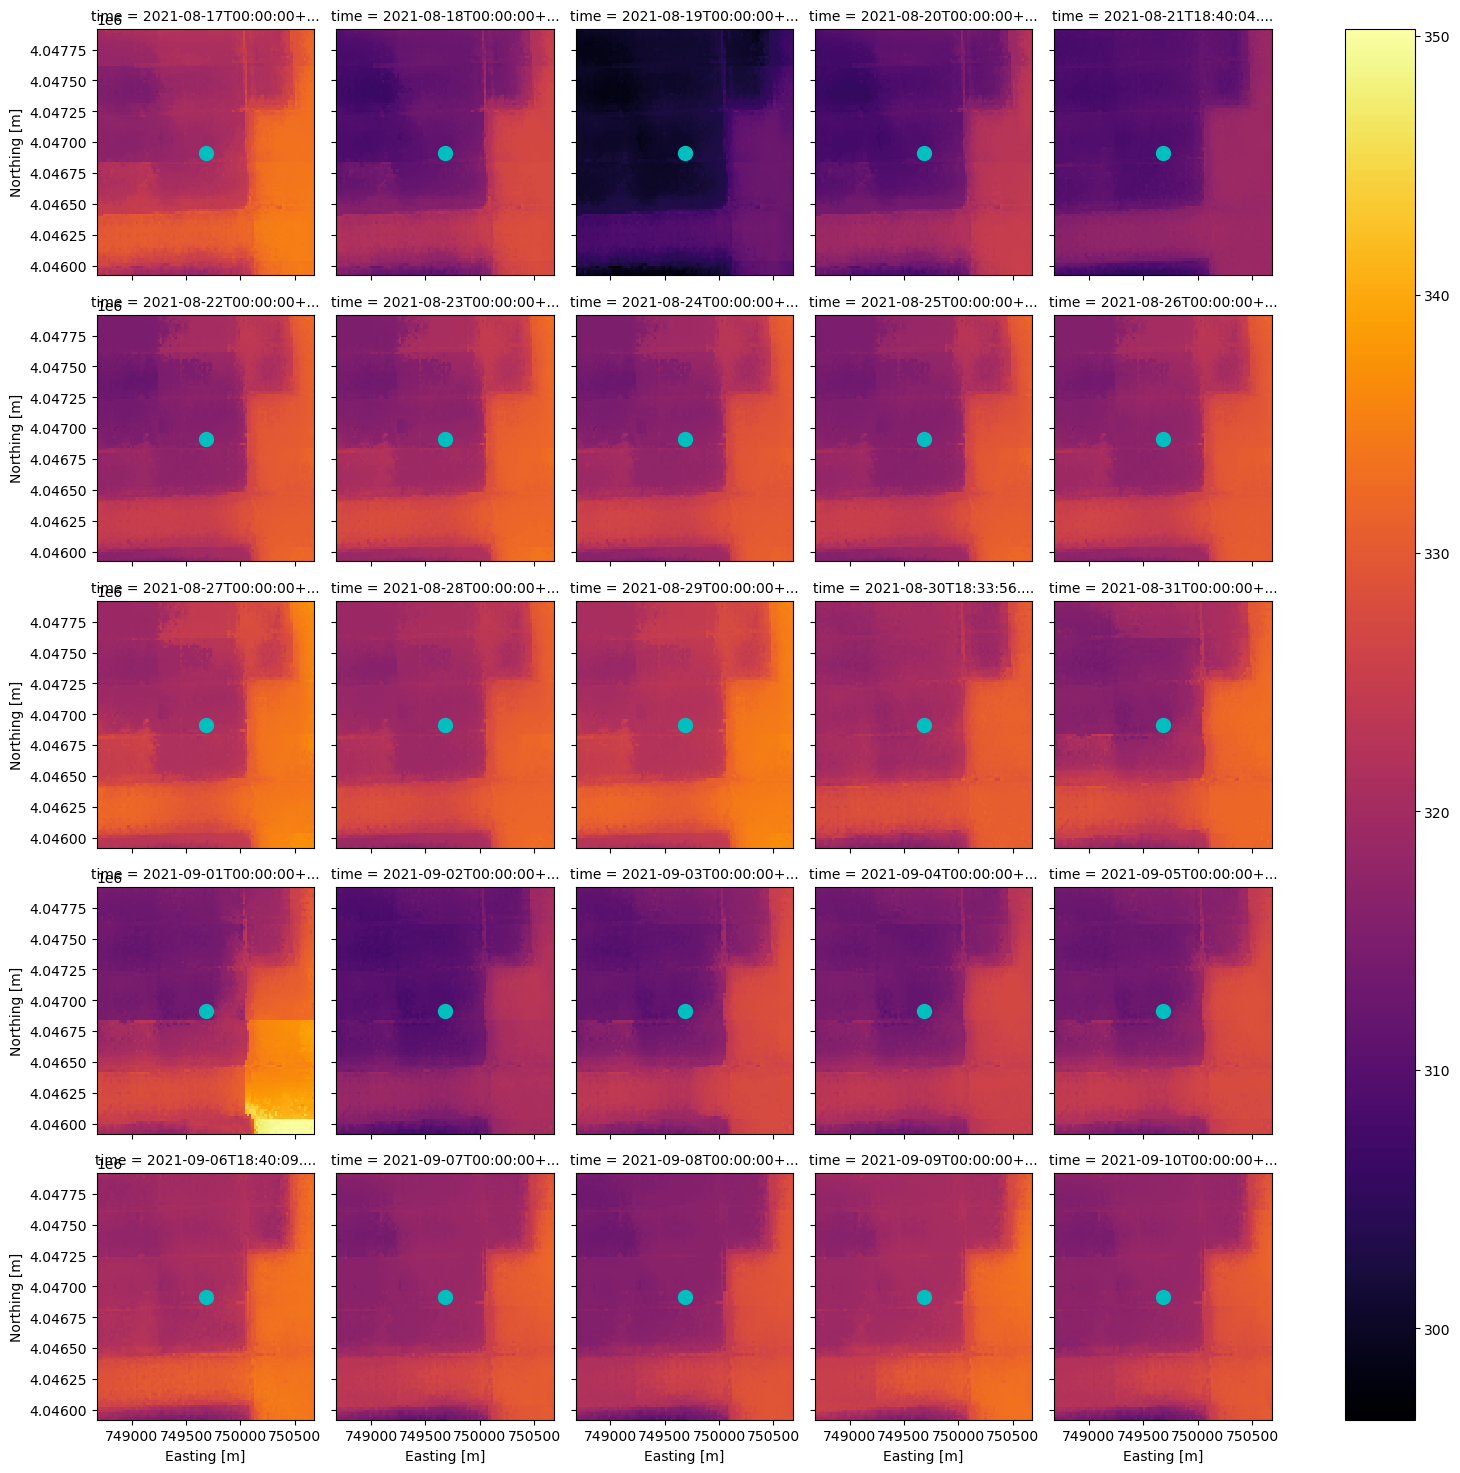

In [28]:
centroid = poly_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') # change 'Center Pixel' for plot title

ax = hdst_ds_clip.plot(x='x', y='y', col='time', col_wrap=5, cmap='inferno')
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="c"))
plt.show()

We can construct a boolean mask to exclude any data which does not have all clear observations, and compare the time series for the point location to data which is not masked.

(If you want to include more QA values in the masking, re-use the code in the plotting helper function we defined at the top of this notebook in combination with this example.)

In [29]:
qa_ds_clip_masked = xr.where(qa_ds_clip > 0, 0., 1.)
hdst_ds_clip_masked = xr.where(qa_ds_clip_masked == 0., np.nan, hdst_ds_clip)

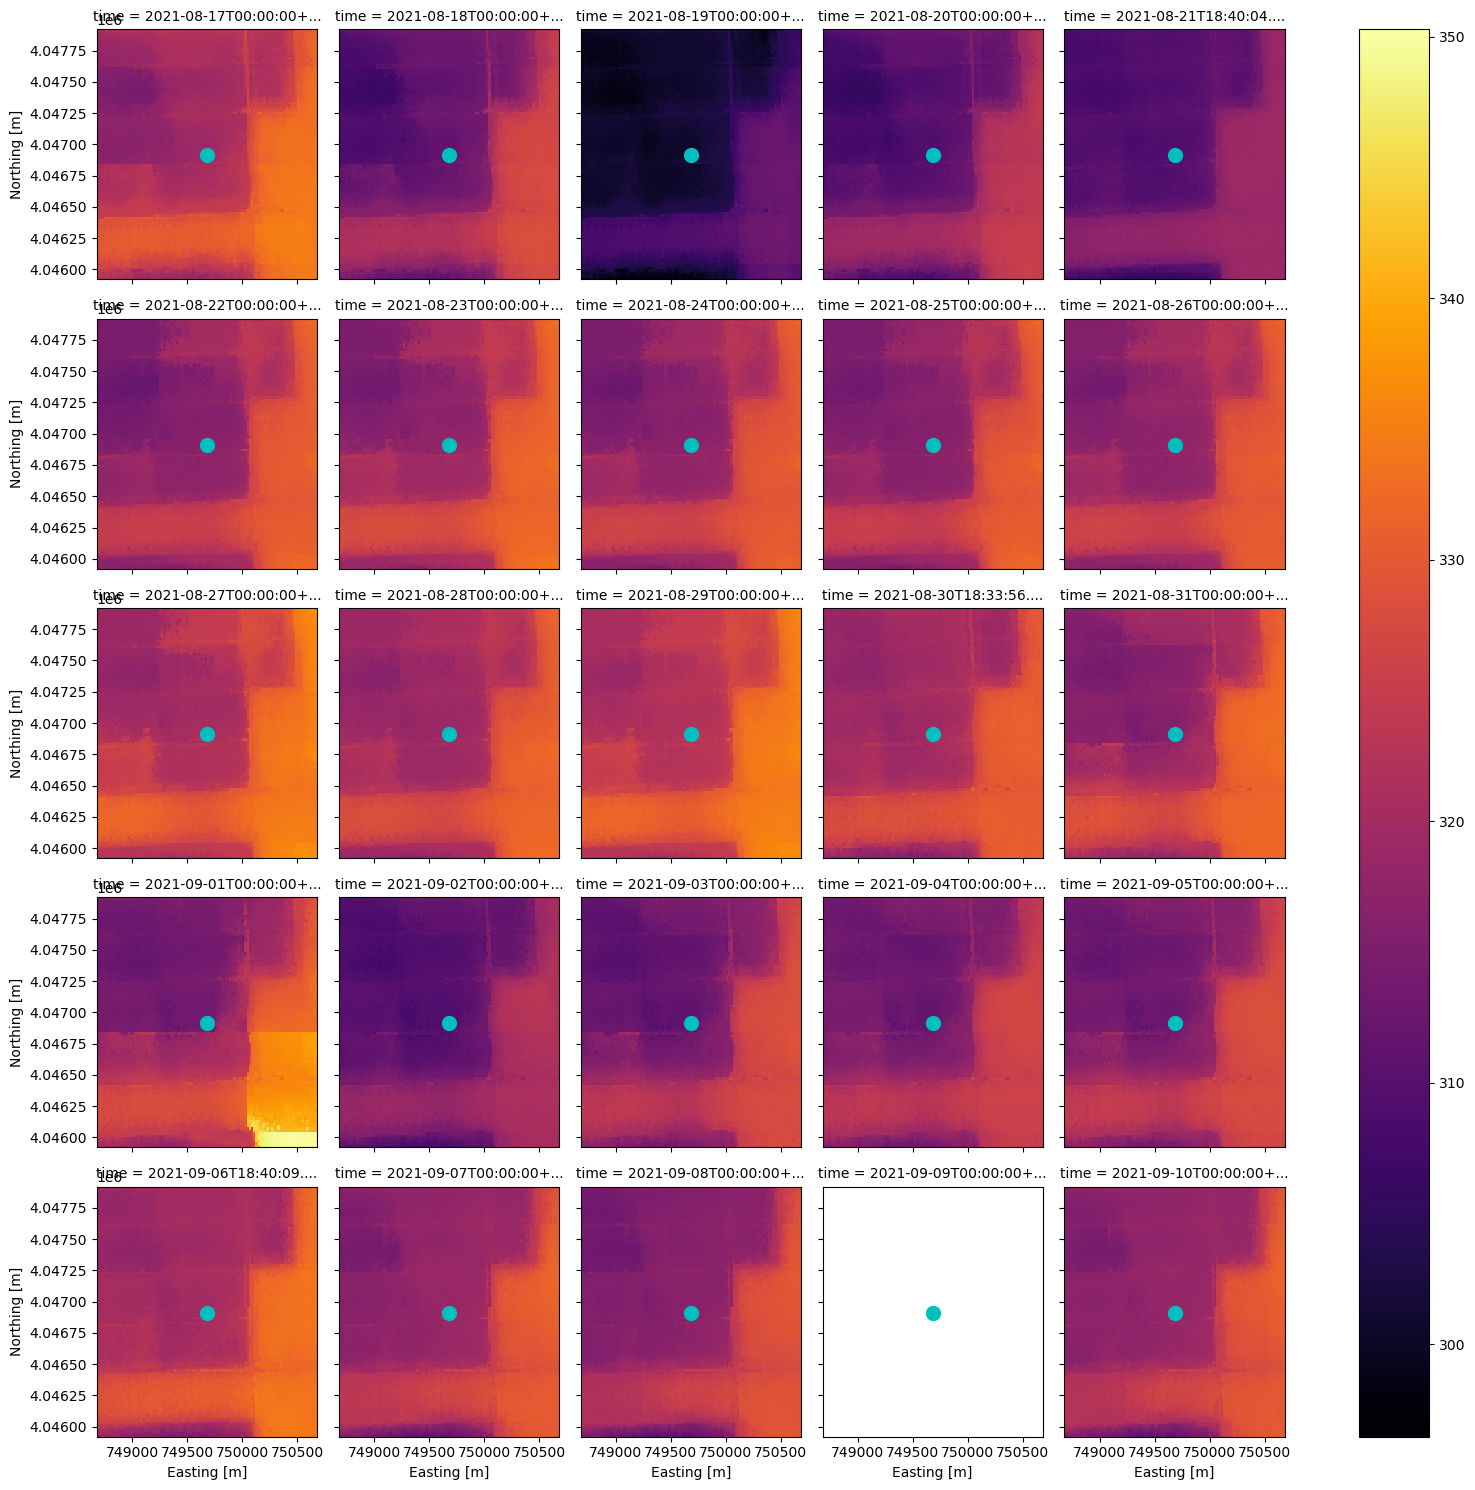

In [30]:
ax = hdst_ds_clip_masked.plot(x='x', y='y', col='time', col_wrap=5, cmap='inferno')
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="c"))
plt.show()

Now we can plot the time series for both datasets, with and without QA masking. Most of the data points will be exactly the same, so for display purposes we will artifically add 1K to the QA masked time series.

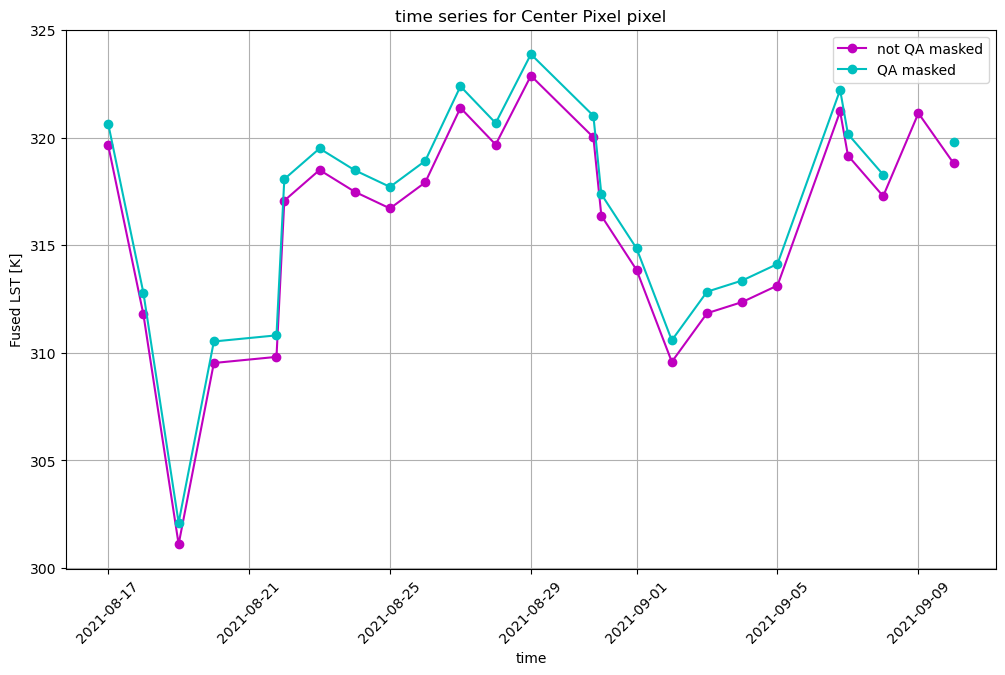

In [31]:
fig, ax = plt.subplots(figsize=(12,7))
hdst_ds_clip.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(ax=ax, marker='o', c='m', label='not QA masked')

# artifically offset for display
(hdst_ds_clip_masked+1).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(ax=ax, marker='o', c='c', label='QA masked')
plt.title(f'time series for {pixtype} pixel')
plt.grid(True)
plt.legend()
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()